# How to Interpolate?

In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py
#import datetime

#math
import numpy as np
import math
import scipy.fftpack
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate
pd.TimeSeries = pd.Series 

#gps
from geopy import distance

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation  

In [2]:
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='constant')

In [3]:
#ROS TIME IS ALREADY WITH REFERENCE FROM EPOCH HENCE NO NEED TO SUBTRACT FROM 1970
def epoch_setup(df):
    #a=dt.datetime.utcfromtimestamp(0)
    #dtx = []
    #converting timestamp to datetime format; subtracting from epoch and converting back to seconds
    #for i in range (len(df.time)):
    #    dtx.append((dt.datetime.fromtimestamp(df.time[i])-a).total_seconds()) 
    #df.insert(1,'epoch',dtx)
    sync_time = df.time-df.time[0]
    df.insert(1,'sync_time',sync_time)
    return df

### Location of Wind Sensor & Source

31.988526614621183


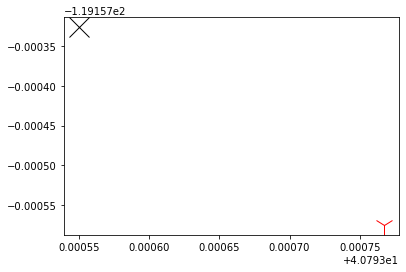

In [4]:
#distance between windstation and odor source
plt.plot([40.79355], [-119.157326], marker='x', markersize=20, color="black")
plt.plot([40.79376709443614], [-119.15757512132207], marker='1', markersize=20, color="red")

#5 inches; 0.127 meters; 12.7 cm

from geopy import distance
coords_1 = (40.79355, -119.157326)
coords_2 = (40.79376709443614, -119.15757512132207)

print (distance.geodesic(coords_1, coords_2).meters)

### Using Rosbag Pandas to import Bag

In [5]:
# import rosbag_pandas
# filename = '/home/ecc/data/dataOctoberBags/OctoberDesertData/Run02/OctoberDesert1020_0.bag'
# df= rosbag_pandas.bag_to_dataframe(filename, exclude=['/imu/data','imu/mag', '/rosout','/rosout_agg','/ublox_gps/fix_velocity', '/ublox_gps/rxmrtcm'],include=['/analog_output', '/trisonica', '/ublox_gps/fix'])
# df.columns=df.columns.str.replace(r"/", "_")
# sync_time = df.index-df.index[0]
# df.insert(0,'sync_time',sync_time)

### Save cleaned bag as H5 

In [6]:
#df.to_hdf('~/data/dataOctoberBags/OctoberDesertData/Run02/OctoberDesert1020_0.h5', key='df', mode='w')

### Load H5

In [7]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/'
exter_load = 'Run03/OctoberDesert1020_5.h5'
exter_save = 'Run03/Interpolated_5.h5'

In [8]:
df=pd.read_hdf(dir+exter_load)

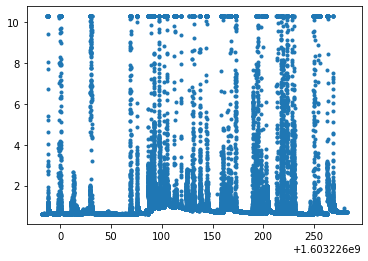

In [9]:
fig = plt.figure()
ax= fig.add_subplot(111)
#plt.plot(df.index, df._trisonica_westeast, '.')
#plt.plot(df.index, df._trisonica_northsouth, '.')
plt.plot(df.index, df._analog_output_data, '.')

### Getting the GPS and WindSensor Time

In [10]:
df["trisonica_time"] = df._trisonica_header_stamp_secs + (df._trisonica_header_stamp_nsecs*1e-9)
df["gps_time"] = df._ublox_gps_fix_header_stamp_secs+(df._ublox_gps_fix_header_stamp_nsecs*1e-9)

In [11]:
df.index[0]  ## checking time resolution

1603225982.0978985

In [12]:
df.keys()    ## checking index headers

Index(['sync_time', '_trisonica_direction', '_trisonica_header_frame_id',
       '_trisonica_header_seq', '_trisonica_header_stamp_nsecs',
       '_trisonica_header_stamp_secs', '_trisonica_humidity',
       '_trisonica_northsouth', '_trisonica_pitch', '_trisonica_pressure',
       '_trisonica_roll', '_trisonica_speed', '_trisonica_temperature',
       '_trisonica_updown', '_trisonica_westeast', '_ublox_gps_fix_altitude',
       '_ublox_gps_fix_header_frame_id', '_ublox_gps_fix_header_seq',
       '_ublox_gps_fix_header_stamp_nsecs', '_ublox_gps_fix_header_stamp_secs',
       '_ublox_gps_fix_latitude', '_ublox_gps_fix_longitude',
       '_ublox_gps_fix_position_covariance_0',
       '_ublox_gps_fix_position_covariance_1',
       '_ublox_gps_fix_position_covariance_2',
       '_ublox_gps_fix_position_covariance_3',
       '_ublox_gps_fix_position_covariance_4',
       '_ublox_gps_fix_position_covariance_5',
       '_ublox_gps_fix_position_covariance_6',
       '_ublox_gps_fix_position_c

### Separating ODOR, WIND, GPS in dataframes

In [2]:
df_odor = pd.DataFrame({'odor_time': df.index,'odor': df._analog_output_data,})
df_wind = pd.DataFrame({'wind_time': df.trisonica_time,'trisonica_U': df._trisonica_westeast,'trisonica_V': df._trisonica_northsouth, })
df_gps = pd.DataFrame({'gps_time': df.gps_time,'lat': df._ublox_gps_fix_latitude,'lon': df._ublox_gps_fix_longitude, })


NameError: name 'df' is not defined

#### Creating time column for odor by dropping NaNs

In [14]:
df_odor
df_odor = df_odor[df_odor.odor.notna()]
df_odor

,odor_time,odor
1.603226e+09,1.603226e+09,0.627272
1.603226e+09,1.603226e+09,0.626021
1.603226e+09,1.603226e+09,0.625083
1.603226e+09,1.603226e+09,0.628836
1.603226e+09,1.603226e+09,0.624457
...,...,...
1.603226e+09,1.603226e+09,0.693277
1.603226e+09,1.603226e+09,0.690149
1.603226e+09,1.603226e+09,0.691400
1.603226e+09,1.603226e+09,0.692026


### Combined time from three sensors and arrange based on time

In [15]:
dfn = pd.concat([df_odor, df_wind, df_gps], sort=True)
combined_time = np.hstack([df_odor.odor_time, df.trisonica_time ,df.gps_time])

In [16]:
dfn['time'] = combined_time
dfn = dfn.sort_values(by=['time'])

In [17]:
dfn

,gps_time,lat,lon,odor,odor_time,trisonica_U,trisonica_V,wind_time,time
1.603226e+09,1.603226e+09,40.793869,-119.157548,NaN,NaN,NaN,NaN,NaN,1.603226e+09
1.603226e+09,1.603226e+09,40.793868,-119.157545,NaN,NaN,NaN,NaN,NaN,1.603226e+09
1.603226e+09,1.603226e+09,40.793867,-119.157542,NaN,NaN,NaN,NaN,NaN,1.603226e+09
1.603226e+09,1.603226e+09,40.793865,-119.157540,NaN,NaN,NaN,NaN,NaN,1.603226e+09
1.603226e+09,1.603226e+09,40.793864,-119.157537,NaN,NaN,NaN,NaN,NaN,1.603226e+09
...,...,...,...,...,...,...,...,...,...
1.603226e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.603226e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.603226e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.603226e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Find Master Time 

In [18]:
dt_odor = np.median(np.diff(dfn.odor_time.dropna().values))
print('dt Odor: ', dt_odor)
dt_wind = np.median(np.diff(dfn.wind_time.dropna().values))
print('dt Wind: ', dt_wind)
dt_gps = np.median(np.diff(dfn.gps_time.dropna().values))
print('dt Gps: ', dt_gps)

dt Odor:  0.004995822906494141
dt Wind:  0.024992942810058594
dt Gps:  0.20000004768371582


In [19]:
first_time = np.max([dfn.odor_time.min(), dfn.wind_time.min(), dfn.gps_time.min()])
last_time = np.min([dfn.odor_time.max(), dfn.wind_time.max(), dfn.gps_time.max()])

In [20]:
master_time = np.arange(first_time, last_time, dt_odor)

### Create Interpolation function

In [21]:
# create interpolation function and inteprolate sensor 1
df_odor_1= dfn[['odor_time', 'odor']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_1.odor_time, df_odor_1.odor)
interp_odor = func_interp_sensor_1(master_time)

In [22]:
df_wind_1= dfn[['wind_time', 'trisonica_U']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_1.wind_time, df_wind_1.trisonica_U)
interp_wind_U = func_interp_sensor_1(master_time)

df_wind_2= dfn[['wind_time', 'trisonica_V']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_2.wind_time, df_wind_2.trisonica_V)
interp_wind_V = func_interp_sensor_1(master_time)

In [23]:
df_gps_lat= dfn[['gps_time', 'lat']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_lat.gps_time, df_gps_lat.lat)
interp_gps_lat = func_interp_sensor_1(master_time)

df_gps_lon= dfn[['gps_time', 'lon']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_gps_lon.gps_time, df_gps_lon.lon)
interp_gps_lon = func_interp_sensor_1(master_time)

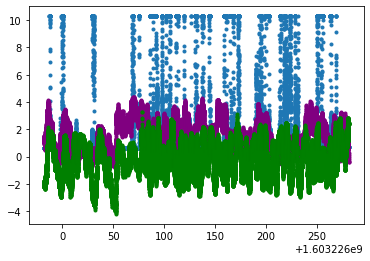

In [24]:
plt.plot(master_time, interp_odor, '.')
plt.plot(master_time, interp_wind_U, '.', color='purple')
plt.plot(master_time, interp_wind_V, '.', color='green')

### New Interpolated Dataframe

In [25]:
new_df = pd.DataFrame({'master_time': master_time,
                           'odor': interp_odor,
                           'trisonica_U': interp_wind_U,
                           'trisonica_V': interp_wind_V,
                           'lat': interp_gps_lat,
                           'lon': interp_gps_lon})

In [26]:
new_df

,master_time,odor,trisonica_U,trisonica_V,lat,lon
0,1.603226e+09,0.627272,1.103435,-2.259672,40.793861,-119.157532
1,1.603226e+09,0.626049,1.137027,-2.216200,40.793861,-119.157532
2,1.603226e+09,0.625092,1.170620,-2.172727,40.793861,-119.157532
3,1.603226e+09,0.628726,1.204212,-2.129255,40.793861,-119.157532
4,1.603226e+09,0.624702,1.237805,-2.085782,40.793861,-119.157532
...,...,...,...,...,...,...
59785,1.603226e+09,0.689895,-0.366031,2.373435,40.793807,-119.157633
59786,1.603226e+09,0.695684,-0.216185,2.397410,40.793807,-119.157633
59787,1.603226e+09,0.691465,-0.066340,2.421386,40.793807,-119.157633
59788,1.603226e+09,0.692953,0.083506,2.445361,40.793807,-119.157633


### Saving Interpolated Bag

In [27]:
new_df.to_hdf(dir+exter_save, key='new_df', mode='w')

In [28]:
dfi= pd.read_hdf(dir+exter_save)

In [29]:
time= dfi.master_time-dfi.master_time[0]
dfi.insert(1,'sync_time',time) 

In [30]:
font = {'size'   : 15}
plt.rc('font', **font)


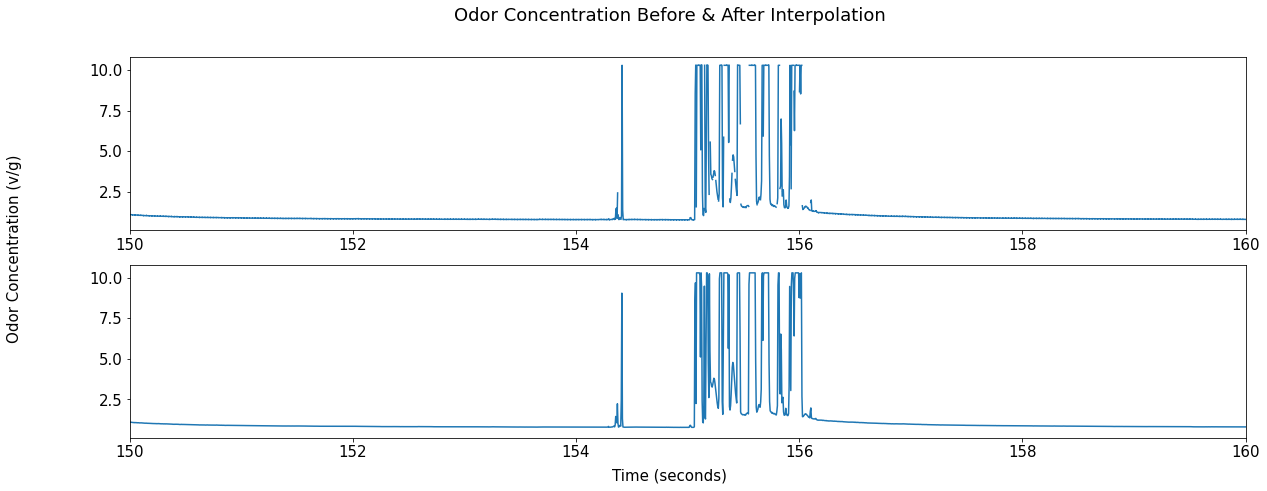

In [31]:
f, (ax1,ax2) = plt.subplots(2, 1,figsize=(20,7))

f.suptitle('Odor Concentration Before & After Interpolation')
ax1.plot(df.sync_time,df._analog_output_data)
#ax1.set_xlabel('Time (seconds)')
#ax1.set_ylabel('Odor Concentration (v/g)')
ax1.set_xlim(150,160)

ax2.plot(dfi.sync_time,dfi.odor)
ax2.set_xlim(150,160)
#ax2.set_xlabel('Time (seconds)')
#ax2.set_ylabel('Odor Concentration (v/g)')
#plt.xlabel('Time (seconds)')
#plt.ylabel('Odor Concentration (v/g)')
f.text(0.5, 0.04, 'Time (seconds)', ha='center')
f.text(0.04, 0.5, 'Odor Concentration (v/g)', va='center', rotation='vertical')
dir = '../../../Research/Images/recurringplots/'
#f.savefig('../../../figure/odor_b&a_interp.jpg')
#f.tight_layout()